In [7]:
from matplotlib import pyplot as plt
from matplotlib import colors as colors
import numpy as np

import sys 
sys.path.append('../')
import Utils.utils as util
from importlib import reload
reload(util)

from sklearn.linear_model import Lasso
from sklearn.multiclass import OneVsRestClassifier

In [8]:
"""
def convert_patch_into_vector(patch):
    h = patch.shape[0]
    #Convert one patch into a column vector for training
    patch = patch.flatten()
    train_y = patch[(h*(h//2)+(h//2))*3:(h*(h//2)+(h//2))*3+3]
    train_x = np.delete(patch, range((h*(h//2)+(h//2))*3, (h*(h//2)+(h//2))*3+3))
    return np.array((train_x, train_y))
"""
    
def convert_patch_into_vector(patch):
    #Convert one patch into a column vector for training
    patch = patch.flatten()

    return np.array(patch)

def convert_vector_into_patch(vector, h):
    #Convert a one column vector into a patch of size h
    return vector.reshape((h,h,7))
    
def convert_patches_into_training_set(patches):
    #Convert a set of patches into a set of vectors
    return np.array(list(map(convert_patch_into_vector, patches))).T

def inpaint_image(noisy_image, dictionary, coord_noisy_pix, h):
    
    for y, x in coord_noisy_pix:
        print("Correction de x : ", x, " et y : ", y)
        label = util.get_patch(x, y, h, noisy_image)
        label = list(convert_patch_into_vector(label))

        print("--- lasso regression ---")
        model = Lasso(fit_intercept=True)
        model.fit(dictionary, label)
        
        coef = model.coef_
        
        print("coef shape : ", coef.shape)
        print("dictionary shape : ", dictionary.shape) 
        
        toto = sum(coef).T * dictionary

        newPixel = get_centered_pixel(model.predict(toto), h)

        print("nouveau pixel : ", newPixel)

        noisy_image[x][y] = newPixel
        util.display_im(noisy_image)

def get_centered_pixel(patch, h):
    #Convert one patch into a column vector for training
    vector = patch[(len(patch)//2):(len(patch)//2)+3]
    return [int(x) for x in vector]
    


taille de l'image :  (256, 256, 3)
nbnoisy: 7251 ,   nbclear: 52285


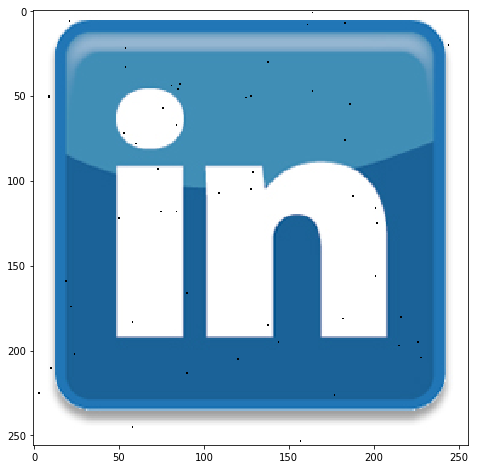

In [9]:
img_matrice = util.read_im("Data/imgdataset/lk.jpg")

#Taille des patchs
h=13

print("taille de l'image : ", img_matrice.shape)

#noisy_image = delete_rect(img_matrice, 400, 400, 500, 100)
#display_im(noisy_image)

#display_im(img_matrice)

#util.display_im(util.get_patch(50, 50, 4, img_matrice))

height = img_matrice.shape[0]
width = img_matrice.shape[1]

noisy_image, noise_pixels = util.noise(img_matrice, 0.0008, width, height, h)

patches = util.get_patches(noisy_image, h, height, width)

noisy_patches = patches[0]
clear_patches = patches[1]

util.display_im(noisy_image)
#print("New patch : ", convert_patch_into_vector(clear_patches[5]))

nbnoisy = np.shape(noisy_patches)[0]
nbclear = np.shape(clear_patches)[0]

print("nbnoisy:", nbnoisy, ",   nbclear:", nbclear)


In [10]:
training = convert_patches_into_training_set(clear_patches)
training.shape

#a, b = zip(*training)
#a = np.array(a)


(507, 52285)

In [11]:
len(noise_pixels)
print(noise_pixels)

[[ 19 159]
 [ 85  46]
 [ 73  93]
 [202 125]
 [226 195]
 [157 253]
 [188 109]
 [ 22 174]
 [ 54  33]
 [128 105]
 [ 10 210]
 [201 116]
 [161   8]
 [177 226]
 [ 90 166]
 [186  55]
 [  9  51]
 [ 86  43]
 [138  30]
 [ 53  72]
 [125  51]
 [144 195]
 [183  76]
 [ 84  67]
 [129  95]
 [244  20]
 [201 156]
 [ 58 183]
 [ 24 202]
 [ 76  57]
 [ 75 118]
 [ 60  78]
 [182 181]
 [ 54  22]
 [  9  50]
 [164   1]
 [228 204]
 [164  47]
 [  3 225]
 [ 84 118]
 [216 180]
 [120 205]
 [ 21   6]
 [ 58 245]
 [ 50 122]
 [183   7]
 [109 107]
 [138 185]
 [ 81  44]
 [128  50]
 [ 90 213]
 [215 197]]


In [ ]:
inpaint_image(noisy_image, training, noise_pixels, h)

Correction de x :  159  et y :  19
--- lasso regression ---


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


coef shape :  (52285,)
dictionary shape :  (507, 52285)
nouveau pixel :  [96, 154, 121]
Correction de x :  46  et y :  85
--- lasso regression ---
coef shape :  (52285,)
dictionary shape :  (507, 52285)
nouveau pixel :  [16, 37, 65]
Correction de x :  93  et y :  73
--- lasso regression ---
